In [ ]:
# Install additional dependencies
!pip3 install mtcnn-opencv
!pip3 install facenet
!pip3 install split-folders
!pip3 install imgaug==0.4.0
!pip3 install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.9 MB 9.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 34.9 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 948 kB 28.6 MB/s 
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.4.0 which is incompatible.
Lo

In [ ]:
import numpy as np
import cv2
import imgaug as ia
import imgaug.augmenters as iaa
import os
import shutil
import splitfolders
import tensorflow as tf
import sys
import pickle
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,classification_report,f1_score, precision_score, recall_score
import facenet.src.facenet as facenet
from mtcnn_cv2 import MTCNN
from google.colab.patches import cv2_imshow
import pandas as pd
import json
import tqdm
detector=MTCNN()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#---------------------------------------------------MANAGE DIR------------------------------------------------#
def dataset_format(data_path):
    """
    Change the directory in the format that is used for training. Remove the y folder from the given dataset directory
    """
    dataset_path=data_path
    for idx,i in enumerate(os.listdir(dataset_path)):
        source_temp=dataset_path+"/"+i
        source=source_temp+'/y'
        for j in os.listdir(source):
            shutil.move(source+"/"+j,source_temp)
        os.rmdir(source)
        print(idx)


def count_images(data_path):
    """
    Count the total number of images in the dataset
    """
    dataset_path=data_path
    count_images=0
    for idx,i in enumerate(os.listdir(dataset_path)):
        source_temp=dataset_path+"/"+i
        image_num=len(os.listdir(source_temp))
        print(image_num)
        count_images+=image_num
    print("Final image count is",count_images)


def duplicate(data_path):
    """
    Check if the dataset folder has only 1 image. If it has only 1 image then create its duplicate. This is done 
    to evaluate model for test set.
    """
    dataset_path=data_path
    count_classes=0
    for idx,i in enumerate(os.listdir(dataset_path)):
        source_temp=dataset_path+"/"+i
        image_num=len(os.listdir(source_temp))
        if image_num==1:
            count_classes+=1
            for j in os.listdir(source_temp):
                s=source_temp+"/"+j
                d=source_temp+"/copy"+j
                shutil.copy(s,d)
                


    print("Total number of classes with only one image is ",count_classes)


In [ ]:
#----------------------------------------------------------SPLIT DATASET---------------------------------------------------------#
def split(input_path,output_path):
    """
        Split the dataset into train (90%) and test set (10%)
    """
    splitfolders.ratio(input_path, output_path, ratio=(.9,0.1))
    print("The folders are split into train and test set")

In [ ]:
#--------------------------------------------------AUGMENTATION OF TRAIN DATA------------------------------------------------------

def augmentation(original_path,augmentation_path,images_per_augmentation):
    """
        Perform dataset augmentation of training set. 
    """
    # Seed for image augmentation
    ia.seed(1)
    # Paths of image and mask
    root_folder = original_path
    outfolder_img   = augmentation_path
    # Number of image to augment 
    num_images=images_per_augmentation
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    if not os.path.exists(outfolder_img):
        os.makedirs(outfolder_img)
    seq = iaa.Sequential([
        iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 20)), 
        iaa.AddToBrightness((-30, 20)),
        iaa.WithHueAndSaturation(
        iaa.WithChannels(0, iaa.Add((0, 10)))),
        
        # In some images move pixels locally around (with random
        # strengths).
        sometimes(
            iaa.ChannelShuffle(0.35, channels=[0, 1])
                    ),
        iaa.MotionBlur(k=5),

        sometimes(
            iaa.Sequential([
                iaa.Affine(shear=(-16, 16)),
            
            ])),
        sometimes(
            iaa.ScaleX((0.5,1)), 
        ),
        sometimes(
        iaa.ScaleY((0.5,1))
        )
        ],random_order=True)
    for idx,img_pth in enumerate(os.listdir(root_folder)):
        total_path=root_folder+img_pth+"/"
        augment_path=outfolder_img+"/"+img_pth+"/"
        print("augmentation path",augment_path)
        print("ID number",idx)
        if not os.path.exists(augment_path):
            os.makedirs(augment_path)
        print("total path is ",total_path)
        for i in range(num_images):
            for file in os.listdir(total_path):
                img_path  = total_path+file
                images = [cv2.imread(img_path)]
                images_aug=seq(images=images)
                outfile_img = outfolder_img+"/"+img_pth+"/"+str(i)+"_"+file
                print(outfile_img)
                cv2.imwrite(outfile_img,images_aug[0])


In [ ]:
#--------------------------------------------------------GENERATE EMBEDDINGS FOR FACENET--------------------------------#
def read_image(file):
    try:
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    except Exception as e:
        exception_type, exception_object, exception_traceback = sys.exc_info()
        line_number = exception_traceback.tb_lineno
        print("Error line number in",line_number)
        print("Error from store_embeddings_facenet/read_image is: ",e)

def pre_process(face, required_size=(160, 160)):

    ret = cv2.resize(face, required_size)
    #ret = cv2.cvtColor(ret, cv2.COLOR_BGR2RGB)
    ret = ret.astype('float32')
    # standardize pixel values across channels (global)
    mean, std = ret.mean(), ret.std()
    ret = (ret - mean) / std
    return ret

def detect_face(haar_cascade_path,frame):

    cascadePath = haar_cascade_path
    faceCascade = cv2.CascadeClassifier(cascadePath)
    gray=cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces=faceCascade.detectMultiScale(gray, 1.2,5)
    if not len(faces)==0:
        for(x,y,w,h) in faces:
            
            face=frame[y:y+h,x:x+w]
            
        
    else:
        face=None
    
    return face

def load_tflite_model(file):
    # Load the TFLite model and allocate tensors.
    interpreter = tf.lite.Interpreter(model_path=file)
    interpreter.allocate_tensors()
    return interpreter

def predict(face_model, sample):
    # Get input and output tensors.
    input_details = face_model.get_input_details()
    output_details = face_model.get_output_details()

    # Test the model on random input data.
    input_shape = input_details[0]['shape']

    #input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
    input_data = sample.reshape(input_shape)
    #input_data = np.expand_dims(input_data, axis=0)
    face_model.set_tensor(input_details[0]['index'], input_data)
    face_model.invoke()
    # The function `get_tensor()` returns a copy of the tensor data.
    # Use `tensor()` in order to get a pointer to the tensor.
    output_data = face_model.get_tensor(output_details[0]['index'])
   
   
    return output_data

def store_embedding(augmented_image_path,tflite_path,haar_cascade_path):
    try:
    
        # Set default dataset path according to user id
        path_data=augmented_image_path
        print("The path data is",path_data)
        img_folder = path_data
        embedding_folder = img_folder+"_embedding/"
        if not os.path.exists(embedding_folder):
            os.makedirs(embedding_folder)

        print("The embedding folder is",embedding_folder)
        # load tfl model
        tflite_model = load_tflite_model(tflite_path)
        for num_idx,sub_folder in enumerate(os.listdir(img_folder)):
            print("Subfolder:",sub_folder)
            print("Class number:",num_idx)
            combined_folder=img_folder+"/"+sub_folder
            for file in os.listdir(combined_folder):
                if file.endswith(".png") or file.endswith(".jpg"):
                    out_folder = embedding_folder+sub_folder
                    
                    if not os.path.exists(out_folder):
                        os.makedirs(out_folder)
                        
                    emb_path = out_folder+"/%s.npz"%file[:-4]
                    if not os.path.exists(emb_path):
                        
                    
                        img = read_image(img_folder+"/"+sub_folder+"/"+file)

                        if img is not None:
                          
                            img=detect_face(haar_cascade_path,img)

                            if img is not None:
                                img = pre_process(img)
                                
                                embeddings = predict(tflite_model, img)
                                np.savez_compressed(emb_path, emb=embeddings)
                                
                                
    except Exception as e:
        exception_type, exception_object, exception_traceback = sys.exc_info()
        line_number = exception_traceback.tb_lineno
        print("Error line number in",line_number)
        print("Error from store_embeddings_facenet is: ",e)

In [ ]:
#------------------------------------------------------TRAIN FACENET EMBEDDING-------------------------------------------------------#
def train_facenet(tflite_path,augmentation_train_path,drive_path):
    try:
        # Set the default tf lite folder        
        tfl_file = tflite_path
        face_model = load_tflite_model(tfl_file)


        input_details = face_model.get_input_details()
        output_details = face_model.get_output_details()

        # Test the model on random input data.
        input_shape = input_details[0]['shape']
        data_dir=augmentation_train_path
        dataset = facenet.get_dataset(data_dir)

        # Check that there are at least one training image per class
        for cls in dataset:
            assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')            

            
        paths, labels = facenet.get_image_paths_and_labels(dataset)
        
        print('Number of classes: %d' % len(dataset))
        print('Number of images: %d' % len(paths))
        
        

        
        # # Run forward pass to calculate embeddings
    
        nrof_images = len(paths)
    
        embedding_size =512
        emb_array = np.zeros((nrof_images, embedding_size))

        for i in range(len(paths)):
            try:
                
                path = paths[i].replace(data_dir,data_dir+"_embedding")
                emb = np.load(path[:-4]+".npz")
                emb_array[i] = emb["emb"]
            except Exception as e:
                exception_type, exception_object, exception_traceback = sys.exc_info()
                line_number = exception_traceback.tb_lineno
                #print("Error in line number {} from train facenet/load numpy array is: {}".format(line_number,e))

        
       
        classifier_file=drive_path+"/trained_GNB_model.pkl"
        classifier_filename_exp = os.path.expanduser(classifier_file)

        # Training the classifier
        print('Training classifier')
        model = GaussianNB()


        model.fit(emb_array, labels)
        temp_predict=model.predict(emb_array)
        acc=accuracy_score(labels,temp_predict)
        print("Training Accuracy {} %".format(acc*100))
        f_score=f1_score(labels,temp_predict, average="macro") 
        p_score=precision_score(labels,temp_predict, average="macro")
        r_score= recall_score(labels,temp_predict, average="macro")
        print("The f1 score is: {} , precision score is: {}, recall score is: {}".format(f_score,p_score,r_score))

        # Create a list of class names
        class_names = [ cls.name.replace('_', ' ') for cls in dataset]

        # Saving classifier model
        with open(classifier_filename_exp, 'wb') as outfile:
            pickle.dump((model, class_names), outfile)
        print('Saved classifier model to file "%s"' % classifier_filename_exp)
        
    except Exception as e:
        exception_type, exception_object, exception_traceback = sys.exc_info()
        line_number = exception_traceback.tb_lineno
        print("Error line number in",line_number)
        print("Error from train facenet is: ",e)


<ipython-input-8-8bb88f75e6b3>:19: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')


In [ ]:
# Set all the paths
drive_path="/content/gdrive/MyDrive/face-recognition"
original_dataset_path=drive_path+"/dataset/LAGdataset_200"
final_dataset_path=drive_path+"/final_dataset"
augmentation_train_path=final_dataset_path+"/train_augmented"
train_path=final_dataset_path+"/train/"
val_path=final_dataset_path+"/val/"
tflite_path=drive_path+'/models/facenet.tflite'

haar_cascade_path=drive_path+"/haarcascade_frontalface_default.xml"

In [ ]:

# Change dataset directory format

dataset_format(original_dataset_path)

In [ ]:
# Count the total images
count_images(original_dataset_path)

# Duplicate the images if only 1 image is present inside a particular class
duplicate(original_dataset_path)

In [ ]:
# Split the dataset
split(original_dataset_path,final_dataset_path)

In [ ]:


# Perform data augmentation
augmentation(train_path,augmentation_train_path,10)

Streaming output truncated to the last 5000 lines.
/content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented/russell_brand/8_22.-Russell-Brand_2.png
/content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented/russell_brand/9_cdcuc6awzla24ubf_2.png
/content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented/russell_brand/9_22.-Russell-Brand_2.png
augmentation path /content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented/albert_einstein/
ID number 669
total path is  /content/gdrive/MyDrive/face-recognition/final_dataset/train/albert_einstein/
/content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented/albert_einstein/0_Marzo_00512_1.png
/content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented/albert_einstein/1_Marzo_00512_1.png
/content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented/albert_einstein/2_Marzo_00512_1.png
/content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented/albert_einst

In [ ]:
# Store embedding for train set

store_embedding(augmentation_train_path,tflite_path,haar_cascade_path)

The path data is /content/gdrive/MyDrive/face-recognition/final_dataset/train_augmented
Subfolder: bryan_cranston
Class number: 0
Subfolder: jessica_biel
Class number: 1
Subfolder: melissa_satta
Class number: 2
Subfolder: kylie_minogue
Class number: 3
Subfolder: konstantin_chabenskij
Class number: 4
Subfolder: naveen_andrews
Class number: 5
Subfolder: anna_semenovich
Class number: 6
Subfolder: lena_headey
Class number: 7
Subfolder: giovanni_ribisi
Class number: 8
Subfolder: billie_joe_armstrong
Class number: 9
Subfolder: hugh_laurie
Class number: 10
Subfolder: randy_couture
Class number: 11
Subfolder: woody_allen
Class number: 12
Subfolder: penelope_cruz
Class number: 13
Subfolder: kate_jackson
Class number: 14
Subfolder: miranda_horz
Class number: 15
Subfolder: 50_cent
Class number: 16
Subfolder: denise_richards
Class number: 17
Subfolder: james_carter
Class number: 18
Subfolder: pharrell_williams
Class number: 19
Subfolder: mario_balotelli
Class number: 20
Subfolder: josh_radnor
Clas

In [ ]:
# Train facenet
train_facenet(tflite_path,augmentation_train_path,drive_path)

Number of classes: 968
Number of images: 13940
Training classifier
Training Accuracy 80.76757532281205 %
The f1 score is: 0.8706864015786936 , precision score is: 0.950678320055885, recall score is: 0.8237168355634266


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Saved classifier model to file "/content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl"


In [ ]:
#-----------------------------------------------INFERENCE FACENET--------------------------------------------------------#

class Identifier:

    def identify(self, embedding,drive_path):
        if embedding is not None:
            classifier_model=drive_path+"/trained_GNB_model.pkl"
            print("The classifier model is", classifier_model)
            with open(classifier_model, 'rb') as infile:
                model, class_names = pickle.load(infile)
            predictions = model.predict_proba(embedding)
            best_class_indices = np.argmax(predictions, axis=1)
            best_class_probabilities = predictions[np.arange(len(best_class_indices)), best_class_indices]
            #print(best_class_indices)
            if best_class_probabilities >= 0.1:
                return class_names[best_class_indices[0]]
            else:
                return '0'

class run_inference:
    def __init__(self,tflite_path):
        self.idt=Identifier()
        self.tfl_file = tflite_path
        self.tflite_model=load_tflite_model(self.tfl_file)
    def main(self,frame,saved_model_path):
        # load tfl model
        try:
            img = pre_process(frame)
            embeddings = predict(self.tflite_model, img)
            faces = self.idt.identify(embeddings.reshape(1, 512),saved_model_path)
            
            return faces
        except Exception as e:
            exception_type, exception_object, exception_traceback = sys.exc_info()
            line_number = exception_traceback.tb_lineno
            print("Error line number in",line_number)
            print("Error from predict using tflite is: ",e)

def final_image_evaluation(image_path,drive_path,tflite_path):
    detector=MTCNN()
    frame=cv2.imread(image_path)

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = detector.detect_faces(rgb)


    r=run_inference(tflite_path)
    class_name=[]
    if len(result) > 0:
        for item in result:
            if item["confidence"]>0.90:
                box_ = item["box"]
                x1 = int(box_[0])
                x2 =  int (box_[2])+x1
                y1 = int (box_[1])
                y2 = int(box_[3])+y1
                face = frame[ y1:y2, x1:x2 ]
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 260, 0), 3)
                
                name=r.main(face,drive_path)
                cv2.putText(frame, name, (x1, y1-30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
                class_name.append(name)

                
        rgb = cv2.putText(frame, f"Number of students in class : {len(class_name)}", (15, 30), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0),2, cv2.LINE_AA)
        df = pd.DataFrame({"names": class_name})
        df.to_csv(drive_path+"/"+"results_of_facenet.csv", index=False)  # save to csv 
        df.to_excel(drive_path+"/"+"results_of_facenet.xlsx",index = None, header=True)  # save to csv     
        cv2_imshow(frame)

        cv2.imwrite(drive_path+"/facenet_final.jpg",frame)

In [ ]:

# Test model on final evaluation image
image_path=drive_path+"/evaluation_image/"+"final.jpg"
tflite_path=drive_path+'/models/facenet.tflite'


The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyDrive/face-recognition/trained_GNB_model.pkl
The classifier model is /content/gdrive/MyD

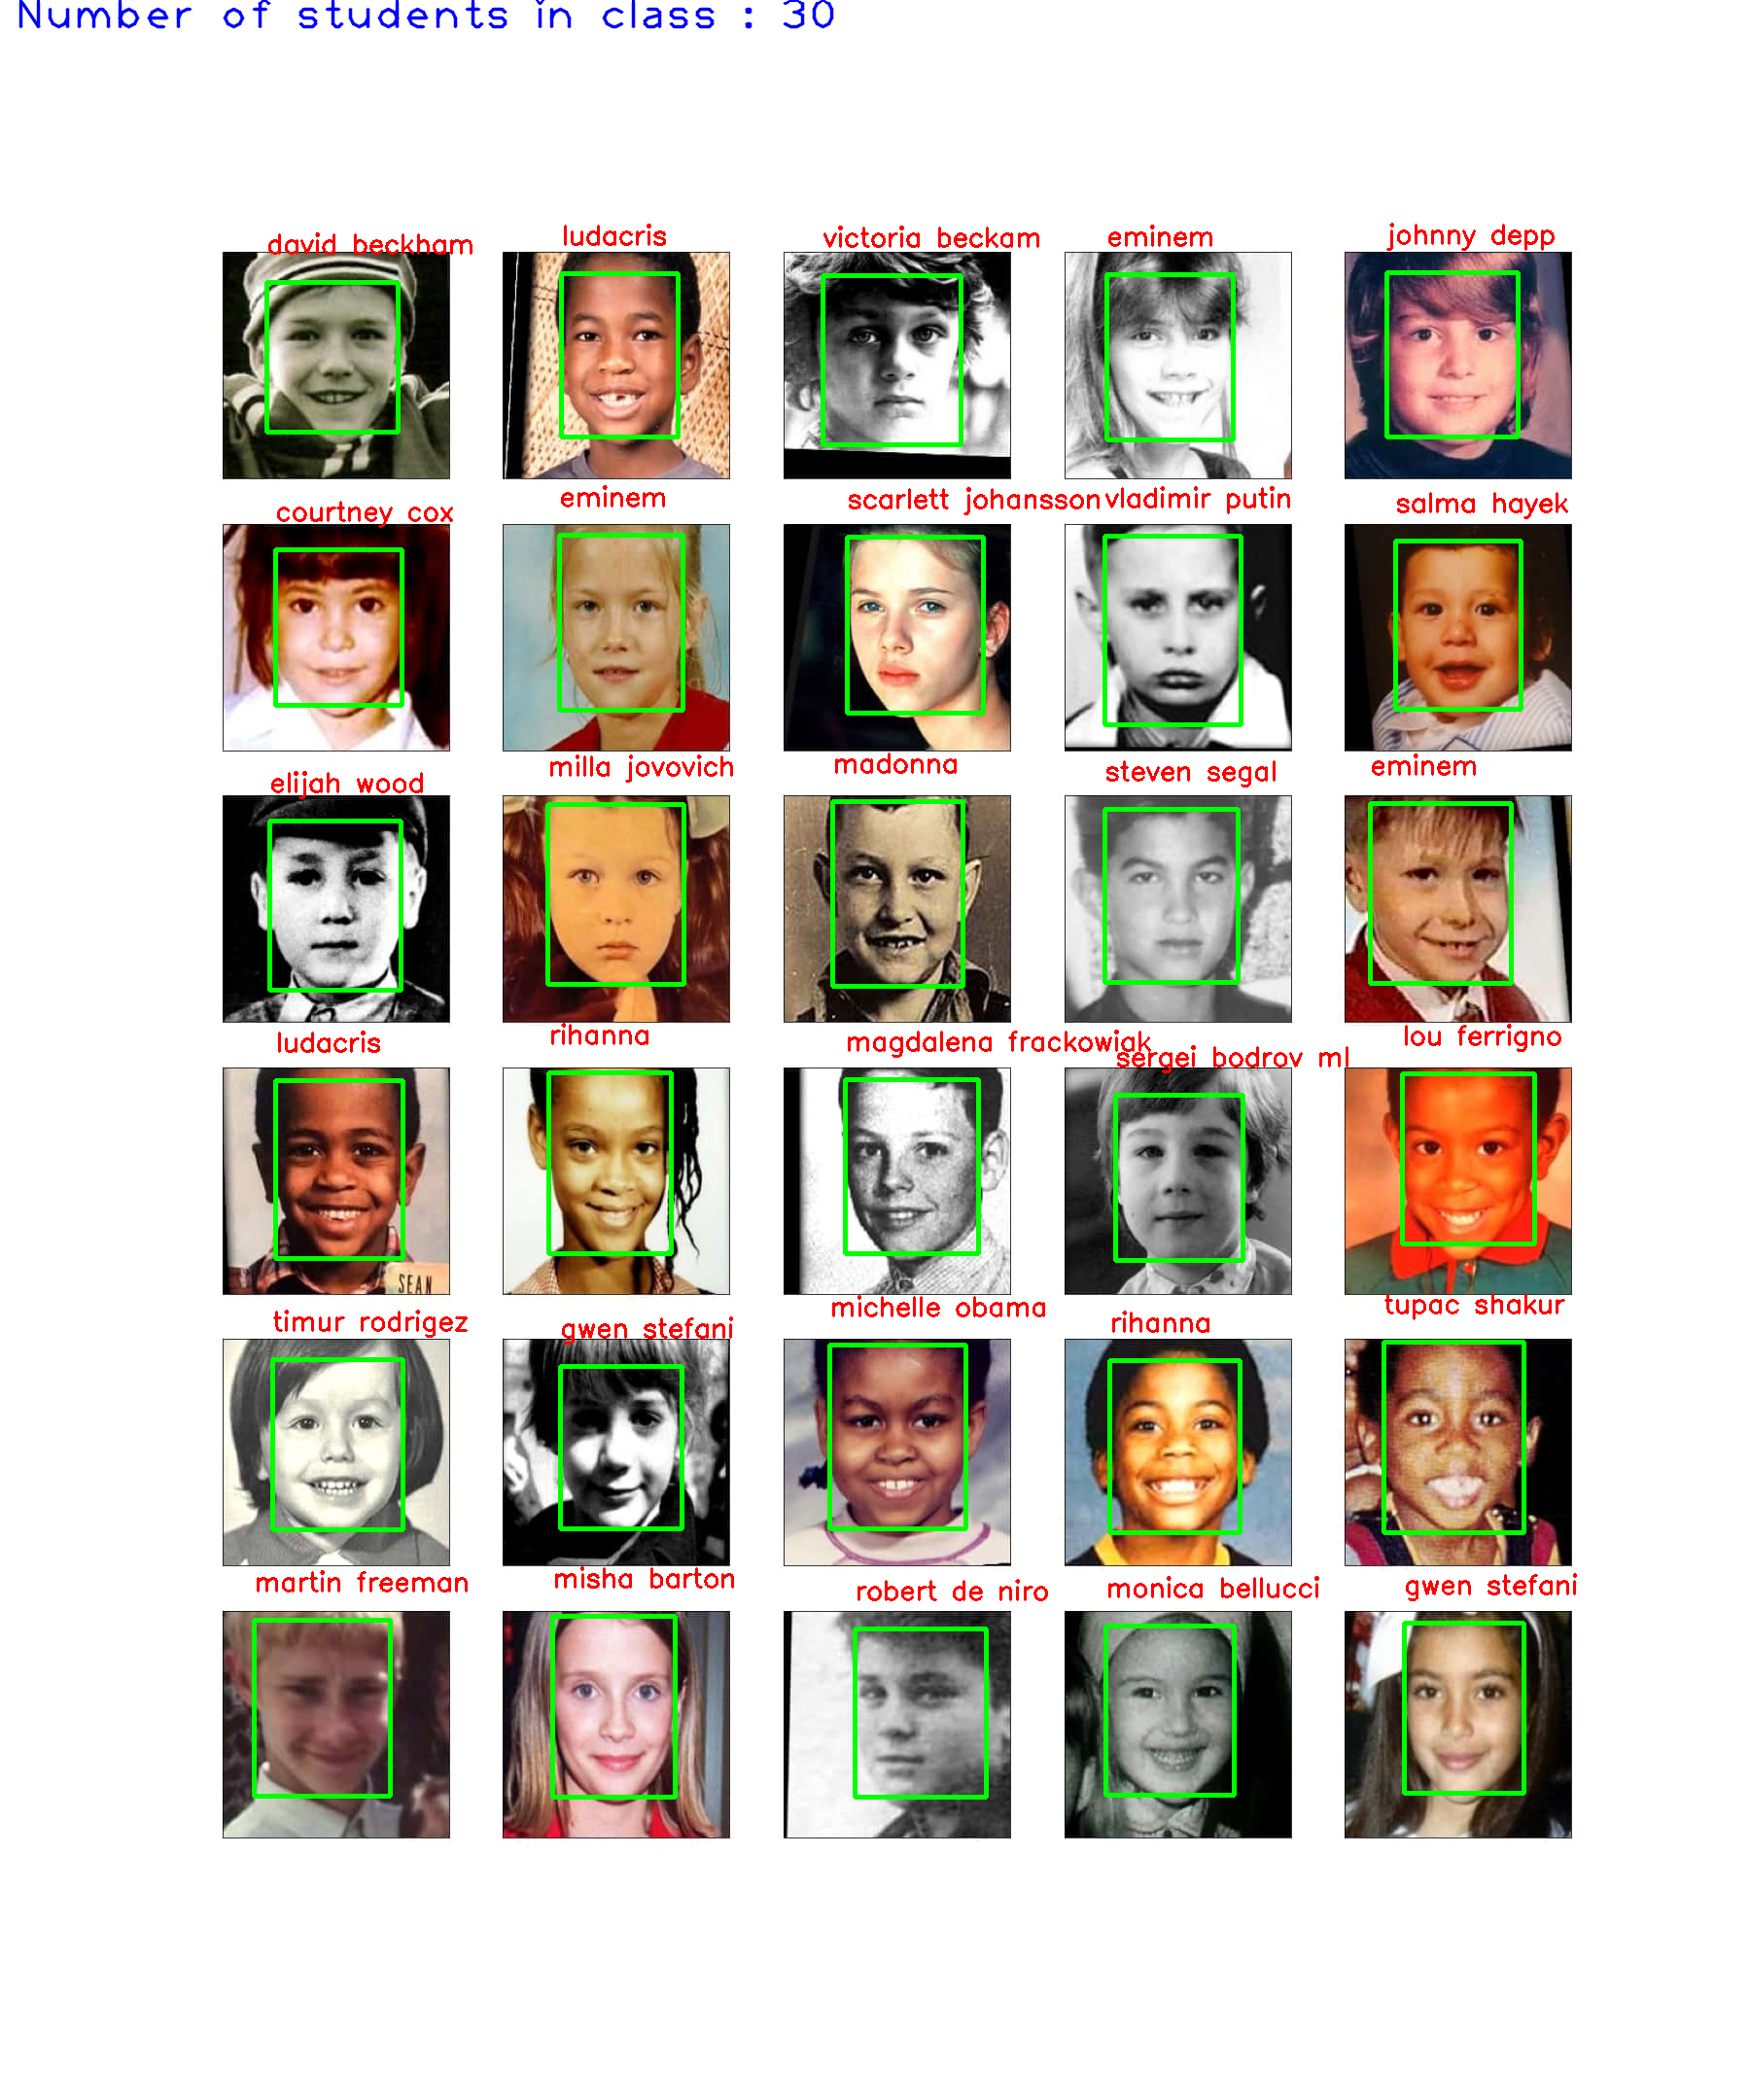

In [ ]:
final_image_evaluation(image_path,drive_path,tflite_path)

In [ ]:
# Calculate accuracy for evaluated image:
total_faces=30
number_of_true_labels=15
accuracy=(number_of_true_labels/total_faces)*100
print("The accuracy for the evaluated final image for facenet is: {}%".format(str(accuracy)))

The accuracy for the evaluated final image for facenet is: 50.0%


In [ ]:
#--------------------------------------------------CALCULATE TEST ACCURACY AND EVALUATE  FOR FACENET----------------------------------------#

def evaluate_facenet(tflite_path,test_path,model_dir):
    try:
        # Set the default tf lite folder        
        tfl_file = tflite_path
        face_model = load_tflite_model(tfl_file)


        input_details = face_model.get_input_details()
        output_details = face_model.get_output_details()

        # Test the model on random input data.
        input_shape = input_details[0]['shape']
        
        test_data_dir=test_path
        dataset = facenet.get_dataset(test_data_dir)

        # Check that there are at least one training image per class
        for cls in dataset:
            assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')            

            
        paths, labels = facenet.get_image_paths_and_labels(dataset)
        
        print('Number of classes: %d' % len(dataset))
        print('Number of images: %d' % len(paths))
        
        print('paths:',paths)

        
        # # Run forward pass to calculate embeddings
    
        nrof_images = len(paths)
    
        embedding_size =512
        emb_array = np.zeros((nrof_images, embedding_size))

        for i in range(len(paths)):
            try:
                print(len(paths)-i)
                path = paths[i].replace(test_data_dir,test_data_dir+"_embedding")
                emb = np.load(path[:-4]+".npz")
                emb_array[i] = emb["emb"]
                
            except Exception as e:
                exception_type, exception_object, exception_traceback = sys.exc_info()
                line_number = exception_traceback.tb_lineno
                #print("Error in line number {} from train facenet/load numpy array is: {}".format(line_number,e))

        
        


        classifier_model=model_dir+"/trained_GNB_model.pkl"
        with open(classifier_model, 'rb') as infile:
            model, class_names = pickle.load(infile)

        predict_test=model.predict(emb_array)
        acc=accuracy_score(labels,predict_test)
        print("Test Accuracy {} % ".format(acc*100))
        f_score=f1_score(labels,predict_test, average="macro") 
        p_score=precision_score(labels,predict_test, average="macro")
        r_score= recall_score(labels,predict_test, average="macro")
        print("The f1 score is: {} , precision score is: {}, recall score is: {}".format(f_score,p_score,r_score))


        
    except Exception as e:
        exception_type, exception_object, exception_traceback = sys.exc_info()
        line_number = exception_traceback.tb_lineno
        print("Error line number in",line_number)
        print("Error from train facenet is: ",e)

<ipython-input-13-e21ff9cd9ea2>:21: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(cls.image_paths)>0, 'There must be at least one image for each class in the dataset')


In [ ]:
# store embedding for test set
val_path=final_dataset_path+"/val"
store_embedding(val_path,tflite_path,haar_cascade_path)


The path data is /content/gdrive/MyDrive/face-recognition/final_dataset/val
The embedding folder is /content/gdrive/MyDrive/face-recognition/final_dataset/val_embedding/
Subfolder: bryan_cranston
Class number: 0
Subfolder: jessica_biel
Class number: 1
Subfolder: melissa_satta
Class number: 2
Subfolder: kylie_minogue
Class number: 3
Subfolder: konstantin_chabenskij
Class number: 4
Subfolder: naveen_andrews
Class number: 5
Subfolder: anna_semenovich
Class number: 6
Subfolder: lena_headey
Class number: 7
Subfolder: giovanni_ribisi
Class number: 8
Subfolder: billie_joe_armstrong
Class number: 9
Subfolder: hugh_laurie
Class number: 10
Subfolder: randy_couture
Class number: 11
Subfolder: woody_allen
Class number: 12
Subfolder: penelope_cruz
Class number: 13
Subfolder: kate_jackson
Class number: 14
Subfolder: miranda_horz
Class number: 15
Subfolder: 50_cent
Class number: 16
Subfolder: denise_richards
Class number: 17
Subfolder: james_carter
Class number: 18
Subfolder: pharrell_williams
Class 

In [ ]:
# Load and Evaluate model for test set
val_path=final_dataset_path+"/val"
evaluate_facenet(tflite_path,val_path,drive_path)

Number of classes: 968
Number of images: 969
paths: ['/content/gdrive/MyDrive/face-recognition/final_dataset/val/50_cent/1382085244_062_1.png', '/content/gdrive/MyDrive/face-recognition/final_dataset/val/aaliyah/copyGennaio_02605_1.png', '/content/gdrive/MyDrive/face-recognition/final_dataset/val/abigail_breslin/images_2.png', '/content/gdrive/MyDrive/face-recognition/final_dataset/val/adam_levine/adam_levine_1.png', '/content/gdrive/MyDrive/face-recognition/final_dataset/val/adam_sandler/Settembre_03418_2.png', '/content/gdrive/MyDrive/face-recognition/final_dataset/val/adele/celebs-then-now-young-old-4_2.png', '/content/gdrive/MyDrive/face-recognition/final_dataset/val/adriana_lima/young_adriana_lima_cm_20120321_00514_002_5.png', '/content/gdrive/MyDrive/face-recognition/final_dataset/val/adriano_pantaleo/copyadriano-pantaleo_1.png', '/content/gdrive/MyDrive/face-recognition/final_dataset/val/agniya_ditkovskite/copyMaggio_03098_2.png', '/content/gdrive/MyDrive/face-recognition/final_

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
#-------------------------------------------------------LBPH---------------------------------------------------
#-------------------------------------------------------------TRAIN-------------------------------------------------------------#
import json
import os
import shutil
import splitfolders
import cv2
import os
import numpy as np
from PIL import Image
import pandas as pd
import json
from sklearn.metrics import accuracy_score
def train_lbph(path,label_mapping,drive_path):
    ###For train the model
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    global detector
    detector = cv2.CascadeClassifier(haar_cascade_path)
    try:
        global faces,Id
        faces, Id = getImagesAndLabels(path,label_mapping)
    except Exception as e:
        l='please make "dataset" folder & put Images'
        print(l)
      
    recognizer.train(faces, np.array(Id)) 
    try:
        model_path=drive_path+"/trained_model_LBPH.yml"
        recognizer.save(model_path)
    except Exception as e:
        q='Please make "model" folder'
       
    res = "Model Trained"
    print("The model is trained....")

def getImagesAndLabels(path,label_mapping):
    global detector
    detector = cv2.CascadeClassifier(haar_cascade_path)

    label_dict={}
    # create empth face list
    faceSamples = []
    # create empty ID list
    Ids = []
    # now looping through all the image paths and loading the Ids and the images
    for idx,class_name in enumerate(os.listdir(path)):
        img_path=path+class_name
        
        for im in os.listdir(img_path):
            img=img_path+"/"+im
            print(img)
            #loading the image and converting it to gray scale
            pilImage = Image.open(img).convert('L')
            # Now we are converting the PIL image into numpy array
            imageNp = np.array(pilImage, 'uint8')
            # getting the Id from the image
            Id = idx
            # extract the face from the training image sample
            faces = detector.detectMultiScale(imageNp)
            
            # If a face is there then append that in the list as well as Id of it
            for (x, y, w, h) in faces:
                faceSamples.append(imageNp[y:y + h, x:x + w])
                Ids.append(Id)
        temp={Id:class_name}
        label_dict.update(temp) 
    with open(label_mapping, 'w') as fp:
        json.dump(label_dict, fp)
    print(label_dict)
    return faceSamples, Ids

In [ ]:
#--------------------------------------------------------EVALUATE----------------------------------------------------------------#
def get_labels(path,drive_path,label_mapping):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    model_path=drive_path+"/trained_model_LBPH.yml"
    recognizer.read( model_path)
    cascadePath = haar_cascade_path
    faceCascade = cv2.CascadeClassifier(cascadePath)
    font = cv2.FONT_HERSHEY_SIMPLEX
    test_path=path
    with open(label_mapping, 'r') as myfile:
        data=myfile.read()

    obj = json.loads(data)
    true_label=[]
    predicted_label=[]
    for idx,class_name in enumerate(os.listdir(path)):
        img_path_temp=test_path+"/"+class_name
        for img in os.listdir(img_path_temp):
            img_path=img_path_temp+"/"+img
            im=cv2.imread(img_path)
            gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
            faces=faceCascade.detectMultiScale(gray, 1.2,5)
            
            for(x,y,w,h) in faces:
                Id, conf = recognizer.predict(gray[y:y+h,x:x+w])
                predicted_class_name=obj.get(str(Id))
                cv2.rectangle(im, (x, y), (x + w, y + h), (0, 260, 0), 3)
                cv2.putText(im, predicted_class_name, (x,y-3),font, 0.8, (255,255,255), 1)
            for key, value in obj.items():
                if class_name == value:
                    
                    true_label.append(int(key))
        
            
            predicted_label.append(int(Id))
    return true_label,predicted_label

def get_accuracy(path,drive_path,label_mapping):    
    true_label,predicted_label=get_labels(path,drive_path,label_mapping)
    acc=accuracy_score(true_label,predicted_label)
    f_score=f1_score(true_label,predicted_label, average="macro") 
    p_score=precision_score(true_label,predicted_label, average="macro")
    r_score= recall_score(true_label,predicted_label, average="macro")
    acc=acc*100
    return acc,f_score,p_score,r_score

In [ ]:
#---------------------------------------------------------------EVALUATE FINAL IMAGE---------------------------------------------#
from google.colab.patches import cv2_imshow
def final_image_evaluation_LBPH(path,drive_path,label_mapping):
    recognizer = cv2.face.LBPHFaceRecognizer_create()
    model_path=drive_path+'/trained_model_LBPH.yml'
    recognizer.read(model_path)
    cascadePath = haar_cascade_path
    faceCascade = cv2.CascadeClassifier(cascadePath)
    font = cv2.FONT_HERSHEY_SIMPLEX
    test_path=path
    with open(label_mapping, 'r') as myfile:
        data=myfile.read()
    faces_coords=[]
    obj = json.loads(data)
    for i in os.listdir(test_path):
        img_path=test_path+"/"+i
        im=cv2.imread(img_path)
        gray=cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
        faces=faceCascade.detectMultiScale(gray, 1.2,5)
        
        for(x,y,w,h) in faces:
            Id, conf = recognizer.predict(gray[y:y+h,x:x+w])
            class_name=obj.get(str(Id))
            cv2.rectangle(im, (x, y), (x + w, y + h), (0, 260, 0), 3)
            cv2.putText(im, class_name, (x,y-30),font, 1, (0,0,255), 2)
            faces_coords.append(class_name)
        rgb = cv2.putText(im, f"Number of students in class : {len(faces_coords)}", (15, 30), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0),2, cv2.LINE_AA)
        df = pd.DataFrame({"names": faces_coords})
        df.to_csv(drive_path+"/"+"results_of_LBPH.csv", index=False)  # save to csv
        df.to_excel(drive_path+"/"+"results_of_LBPH.xlsx", index = None, header=True)  # save to csv
        cv2_imshow(im)    
        cv2.imwrite(drive_path+"/"+"LBPH"+i,im)

In [ ]:

train_path=drive_path+"/dataset/LAGdataset_200/"

label_mapping=drive_path+'/label_mapping_LBPH.json'

In [ ]:

train_lbph(train_path,label_mapping,drive_path)

/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/bryan_cranston/Marzo_01656_1.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/bryan_cranston/Breaking_Bad_00253_2.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/bryan_cranston/98893475_1.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/jessica_biel/22130925_1.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/jessica_biel/znamenitosti-v-detstve-i-seychas-44-foto_15_2.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/jessica_biel/celebs-then-now-young-old-40_1.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/jessica_biel/jessica-biel1_1.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/jessica_biel/jessica-biel_2.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/jessica_biel/Marzo_03422_1.png
/content/gdrive/MyDrive/face-recognition/dataset/LAGdataset_200/jessica_biel/u45F3r7_2

In [ ]:
train_acc,f_score,p_score,r_score=get_accuracy(train_path,drive_path,label_mapping)
print("The training accuracy is: {}% f1 score is: {} precision score is: {} recall is: {}".format(train_acc,f_score,p_score,r_score))

The training accuracy is: 96.9530258146424% f1 score is: 0.9594081308957342 precision score is: 0.9570420110192837 recall is: 0.968887741046832


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


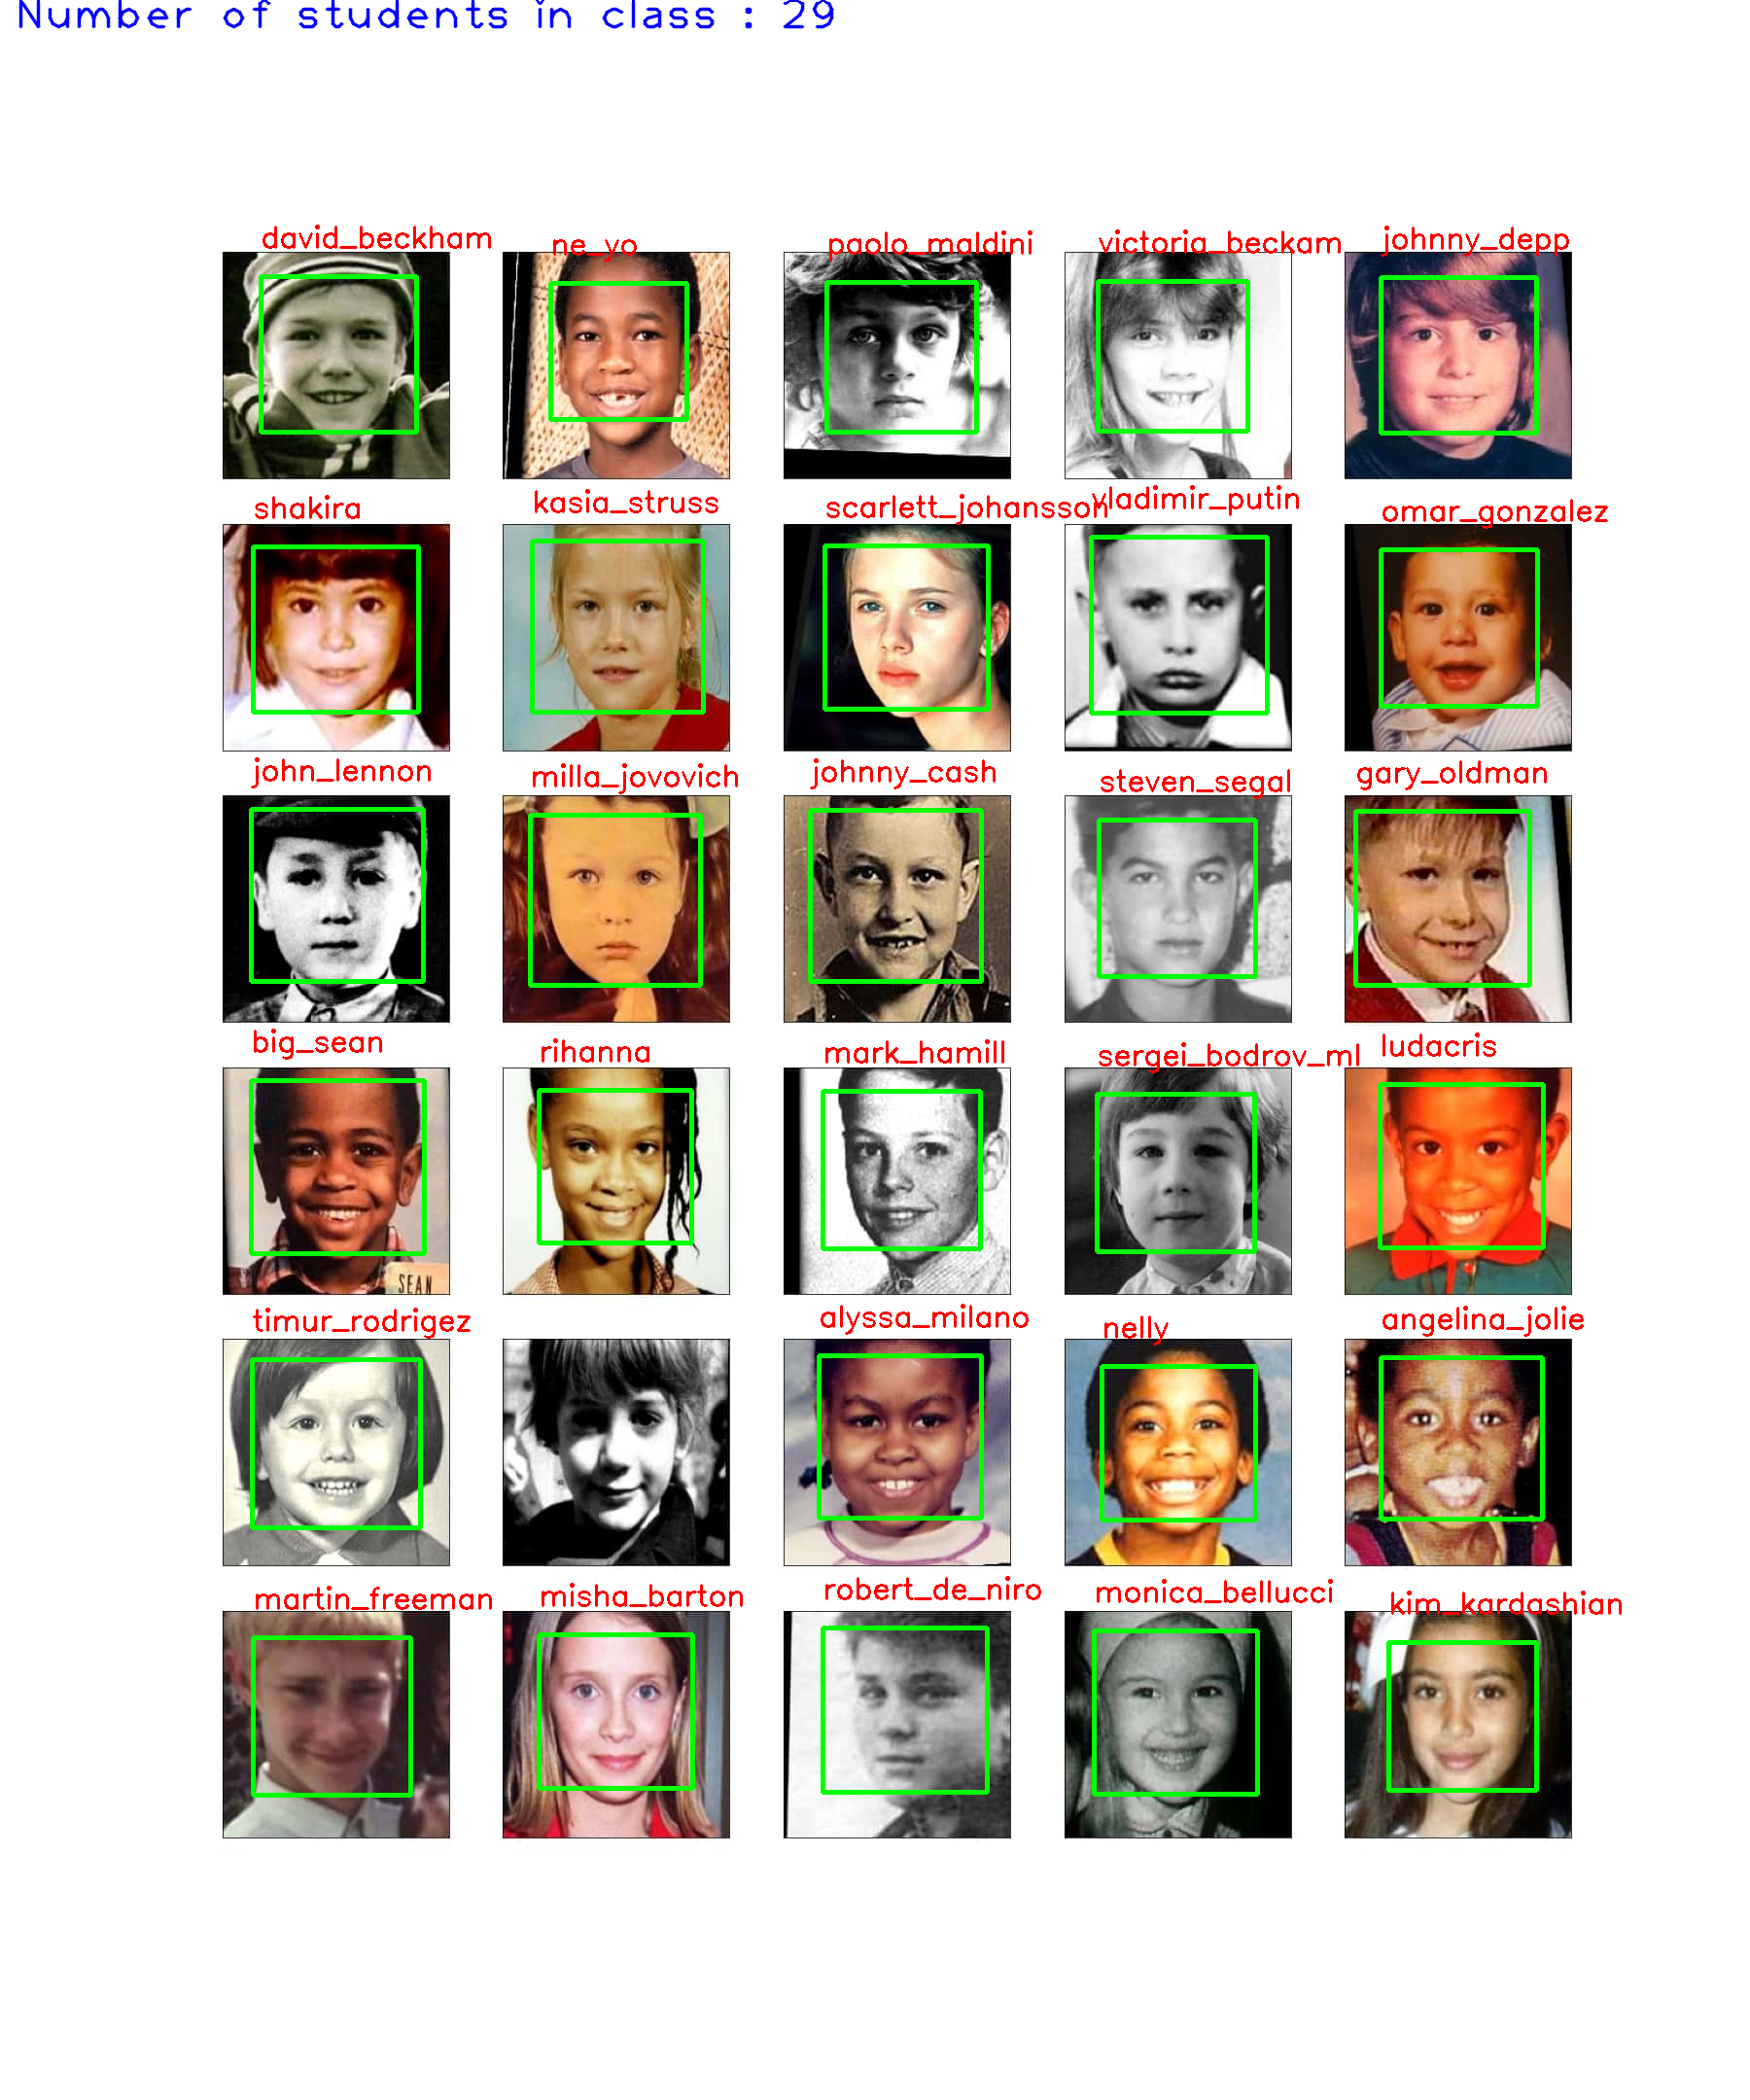

In [ ]:
final_image_path="/content/gdrive/MyDrive/face-recognition/evaluation_image"
final_image_evaluation_LBPH(final_image_path,drive_path,label_mapping)

In [ ]:
# Calculate accuracy for evaluated image:
total_faces=30
number_of_true_labels=25
accuracy=(number_of_true_labels/total_faces)*100
print("The accuracy for the evaluated final image for LBPH is: {}%".format(str(accuracy)))

The accuracy for the evaluated final image for LBPH is: 83.33333333333334%


In [ ]:
#-----------------------------------------------------------------------------INITIALIZE PATHS AND VARIABLES FOR ARCFACE------------------------------------------------------#
faces_arcface = []
label_dict={}
haar_cascade_path=drive_path+"/haarcascade_frontalface_default.xml"
image_path=drive_path+"/evaluation_image"
face_cascade = cv2.CascadeClassifier(haar_cascade_path)  # load opencv face detector
train_data_folder=drive_path+"/dataset/LAGdataset_200"
label_mapping=drive_path+"/label_mapping_ARCFACE.json"
face_rec_database = {}
model_path=drive_path+"/arcface_final_L_Resnet_E_IR.h5"


In [ ]:
# Load model for arcface
model = tf.keras.models.load_model(model_path)  # load face recognition model

In [ ]:
#---------------------------------------------------------------------------------TRAIN ARCFACE-----------------------------------------------------------------#
def add_face(label_mapping):
  for idx,class_name in enumerate(os.listdir(train_data_folder)):
    classes_dir=train_data_folder+"/"+class_name
    print("Added face for class {}: {}".format(idx,class_name))
    for images in os.listdir(classes_dir):
      try:
        path=classes_dir+"/"+images
        
        im = cv2.imread(path) # read image
        rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)  # turn image into rgb, because opencv loads as BGR
        [x,y,w,h] = face_cascade.detectMultiScale(rgb, 1.3, 4)[0] # detect faces and get the firs one's coordinates as x,y,w,h
        face = rgb[y:y + h, x:x + w]  # crop face from image

        face = tf.image.resize(face, (112, 112), method="nearest")  # resize face
        face = (tf.cast(face, tf.float32) - 127.5) / 128.  # normalize face
        
        faces_arcface.append((face, path))  # add to list
      except IndexError:
        continue
    temp={idx:class_name}
    label_dict.update(temp)
  with open(label_mapping, 'w') as fp:
    json.dump(label_dict, fp)
    print(label_dict)

def train():
  for (face, paths) in faces_arcface:
    label = paths.split("/")[-2]
   
    if not label in face_rec_database.keys():  
      output_model = model(tf.expand_dims(face, axis=0), training=False)

      face_rec_database[label] = tf.nn.l2_normalize(output_model)
    

    else:
      output_model = model(tf.expand_dims(face, axis=0), training=False)

      face_rec_database[label] += tf.nn.l2_normalize(output_model)
      face_rec_database[label] /= 2

In [ ]:
#--------------------------------------------------------------------------------EVALUATION OF ARCFACE MODEL---------------------------------------------------------------#
def find_accuracy(folder_dir,label_mapping):
  true_label,predicted_label=get_accuracy(folder_dir,label_mapping)
  acc=accuracy_score(true_label,predicted_label)
  acc=acc*100
  f_score=f1_score(true_label,predicted_label, average="macro") 
  p_score=precision_score(true_label,predicted_label, average="macro")
  r_score= recall_score(true_label,predicted_label, average="macro")
  return acc,f_score,p_score,r_score


def get_accuracy(folder_dir,label_mapping):
  true_label=[]
  labels_of_faces=[]
  predicted_label=[]
  faces_list_acc = []
  with open(label_mapping, 'r') as myfile:
    data=myfile.read()

  obj = json.loads(data)
  for idx,class_name in enumerate(os.listdir(folder_dir)):
    print(" Index: ",idx)
    classes_dir=folder_dir+"/"+class_name
    for images in os.listdir(classes_dir):
      image_path=classes_dir+"/"+images
      im = cv2.imread(image_path)
      rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
      faces_coords = face_cascade.detectMultiScale(rgb, 1.3, 4)
     
      
      result = detector.detect_faces(rgb)
    
      if len(result) > 0:
        for item in result:
            if item["confidence"]>0.85:
                box_ = item["box"]
                x1 = int(box_[0])
                x2 =  int (box_[2])+x1
                y1 = int (box_[1])
                y2 = int(box_[3])+y1
                face = im[ y1:y2, x1:x2 ]
                face = tf.image.resize(face, (112, 112), method="nearest")
                face = (tf.cast(face, tf.float32) - 127.5) / 128. 
                faces_list_acc.append(face)  # same code above
                
                for key, value in obj.items():
                  if class_name == value:          
                    true_label.append(int(key))
    if idx%100==0 and idx!=0:
      outputs_of_faces = tf.nn.l2_normalize(model(tf.convert_to_tensor(faces_list_acc), training=False))   # get embedding features of images with model
      print("batch started")
      cos_dis = tf.keras.losses.CosineSimilarity()
      

      for output in outputs_of_faces:
        min_dist = (100, None)
        for label in face_rec_database:
          output_label_database = face_rec_database[label]
          distance = cos_dis(output_label_database, output) 

          if distance < min_dist[0]:
            min_dist = (distance, label)

        labels_of_faces.append(min_dist[1])
      faces_list_acc=[]
      print("batch done")
   
    elif idx==967:
        print("Last batch ")
        outputs_of_faces = tf.nn.l2_normalize(model(tf.convert_to_tensor(faces_list_acc), training=False))   # get embedding features of images with model
        cos_dis = tf.keras.losses.CosineSimilarity()
        

        for output in outputs_of_faces:
          min_dist = (100, None)
          for label in face_rec_database:
            output_label_database = face_rec_database[label]
            distance = cos_dis(output_label_database, output) 

            if distance < min_dist[0]:
              min_dist = (distance, label)

          labels_of_faces.append(min_dist[1])
        faces_list_acc=[]
  for predicted_item in labels_of_faces:
    for key, value in obj.items():
        if predicted_item == value:          
          predicted_label.append(int(key))
  return true_label,predicted_label

In [ ]:
#-----------------------------------------------------------------------------FINAL IMAGE EVALUATION FOR ARCFACE--------------------------------------------------#
def final_image_evaluation_Arcface(drive_path,path):
  for pth in os.listdir(path):
    image_path=path+"/"+pth
    im = cv2.imread(image_path)
    rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    faces_coords = face_cascade.detectMultiScale(rgb, 1.3, 4)
    faces_list_arcface = []
    result = detector.detect_faces(rgb)
    for x, y, w, h in faces_coords:
        h = h + 5
        face = rgb[y:y + h, x:x + w]

        face = tf.image.resize(face, (112, 112), method="nearest")
        face = (tf.cast(face, tf.float32) - 127.5) / 128. 
        faces_list_arcface.append(face)  # same code above
        cv2.rectangle(rgb, (x, y), (x + w, y + h), (0, 260, 0), 3)


    outputs_of_faces = tf.nn.l2_normalize(model(tf.convert_to_tensor(faces_list_arcface), training=False))   # get embedding features of images with model

    cos_dis = tf.keras.losses.CosineSimilarity()
    labels_of_faces = []
    
    for output in outputs_of_faces:
      min_dist = (100, None)
      for label in face_rec_database:
        output_label_database = face_rec_database[label]
        distance = cos_dis(output_label_database, output) 

        if distance < min_dist[0]:
          min_dist = (distance, label)

      labels_of_faces.append(min_dist[1])
    # this loop does face recognition by comparing the embdegging outputs by using Cosine Distiance method

    for i, (x, y, w, h) in enumerate(faces_coords):  
      rgb = cv2.putText(rgb, labels_of_faces[i], (x,y-30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2)
    # this loop writes names in image
  
    rgb = cv2.putText(cv2.cvtColor(rgb, cv2.COLOR_RGB2BGR), f"Number of students in class : {len(faces_coords)}", (15, 30), cv2.FONT_HERSHEY_PLAIN, 3, (255, 0, 0),2, cv2.LINE_AA)

    df = pd.DataFrame({"names": labels_of_faces})
    df.to_csv(drive_path+"/results_of_Arcface.csv", index=False)  # save to csv
    df.to_excel(drive_path+"/results_of_Arcface.xlsx", index = None, header=True)  # save to excel

    cv2_imshow(rgb)  # display
    cv2.imwrite(drive_path+"/Arcface_final.jpg", rgb) # save to disk
  

In [ ]:
# Add face for Arcface
add_face(label_mapping)



Added face for class 0: bryan_cranston
Added face for class 1: jessica_biel
Added face for class 2: melissa_satta
Added face for class 3: kylie_minogue
Added face for class 4: konstantin_chabenskij
Added face for class 5: naveen_andrews
Added face for class 6: anna_semenovich
Added face for class 7: lena_headey
Added face for class 8: giovanni_ribisi
Added face for class 9: billie_joe_armstrong
Added face for class 10: hugh_laurie
Added face for class 11: randy_couture
Added face for class 12: woody_allen
Added face for class 13: penelope_cruz
Added face for class 14: kate_jackson
Added face for class 15: miranda_horz
Added face for class 16: 50_cent
Added face for class 17: denise_richards
Added face for class 18: james_carter
Added face for class 19: pharrell_williams
Added face for class 20: mario_balotelli
Added face for class 21: josh_radnor
Added face for class 22: alexa_chung
Added face for class 23: maria_poroshina
Added face for class 24: iggy_pop
Added face for class 25: bing

In [ ]:
# Train Arcface
train()

In [ ]:
# Perform Evaluation
train_acc,f_score,p_score,r_score=find_accuracy(train_data_folder,label_mapping)
print("The training accuracy is: {}% f1 score is: {} precision score is: {} recall is: {}".format(train_acc,f_score,p_score,r_score))

 Index:  0
 Index:  1
 Index:  2
 Index:  3
 Index:  4
 Index:  5
 Index:  6
 Index:  7
 Index:  8
 Index:  9
 Index:  10
 Index:  11
 Index:  12
 Index:  13
 Index:  14
 Index:  15
 Index:  16
 Index:  17
 Index:  18
 Index:  19
 Index:  20
 Index:  21
 Index:  22
 Index:  23
 Index:  24
 Index:  25
 Index:  26
 Index:  27
 Index:  28
 Index:  29
 Index:  30
 Index:  31
 Index:  32
 Index:  33
 Index:  34
 Index:  35
 Index:  36
 Index:  37
 Index:  38
 Index:  39
 Index:  40
 Index:  41
 Index:  42
 Index:  43
 Index:  44
 Index:  45
 Index:  46
 Index:  47
 Index:  48
 Index:  49
 Index:  50
 Index:  51
 Index:  52
 Index:  53
 Index:  54
 Index:  55
 Index:  56
 Index:  57
 Index:  58
 Index:  59
 Index:  60
 Index:  61
 Index:  62
 Index:  63
 Index:  64
 Index:  65
 Index:  66
 Index:  67
 Index:  68
 Index:  69
 Index:  70
 Index:  71
 Index:  72
 Index:  73
 Index:  74
 Index:  75
 Index:  76
 Index:  77
 Index:  78
 Index:  79
 Index:  80
 Index:  81
 Index:  82
 Index:  83
 I

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


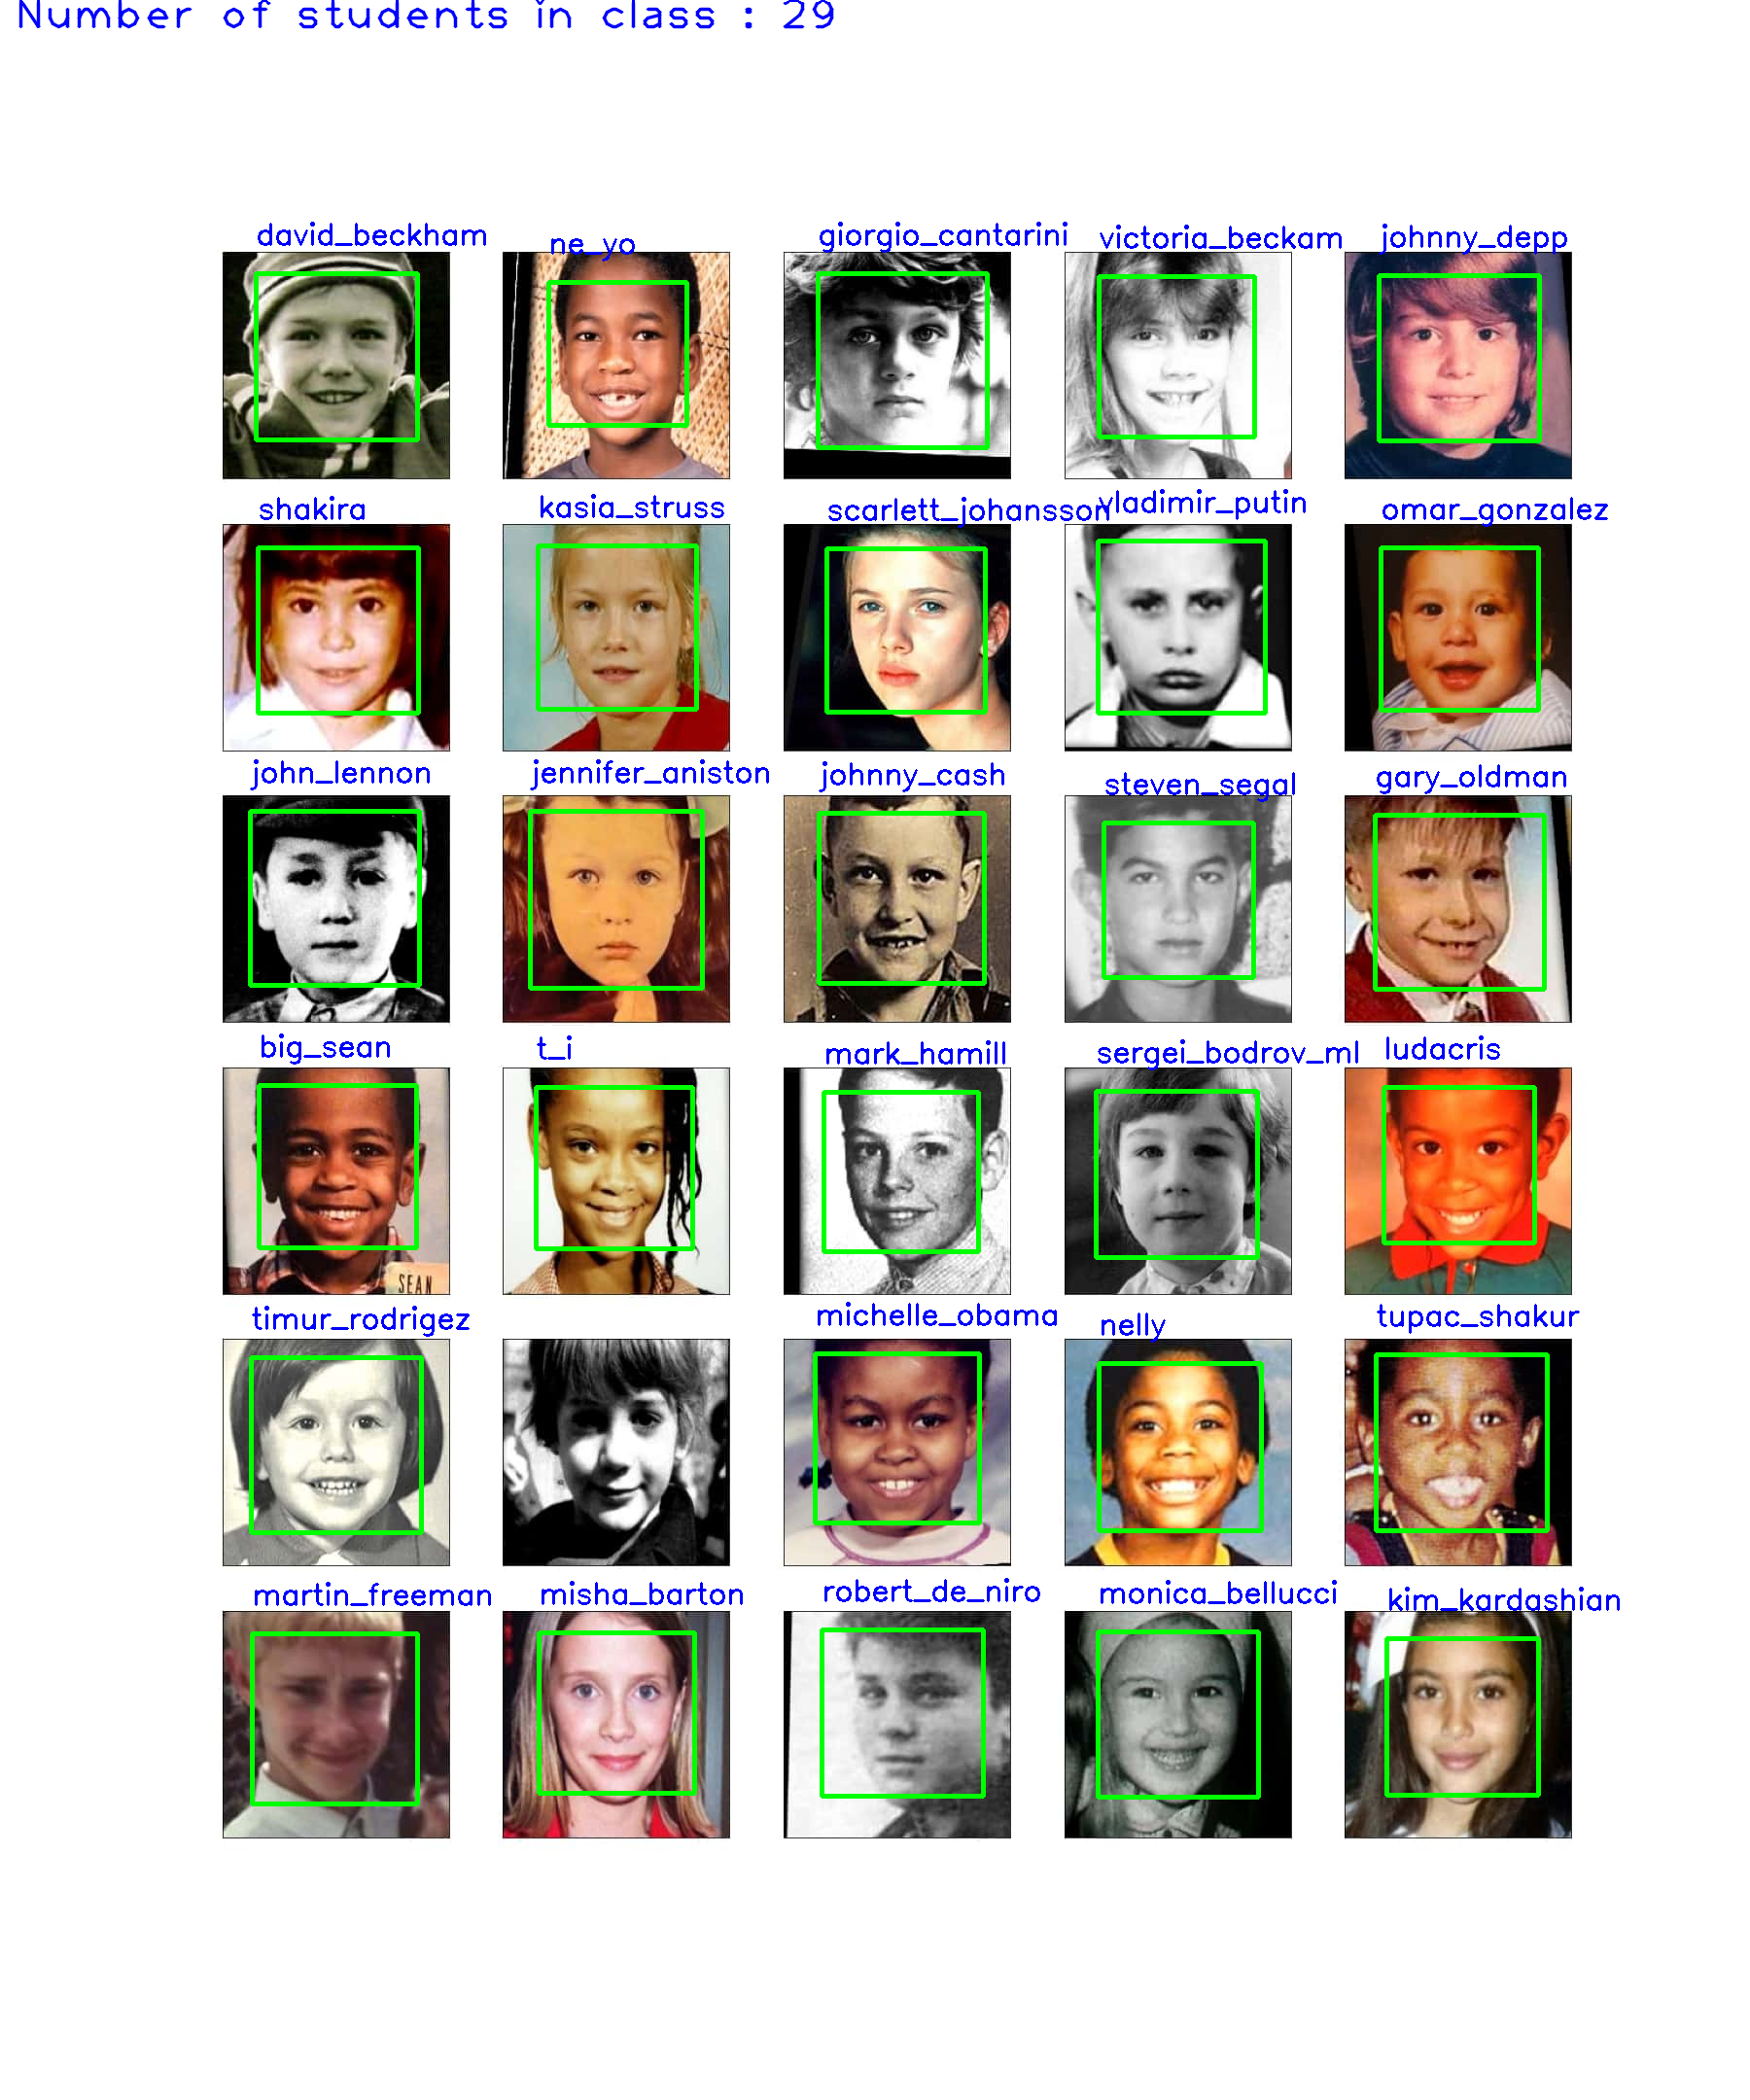

In [ ]:
# Perform final image evaluation
image_path=drive_path+"/evaluation_image"
final_image_evaluation_Arcface(drive_path,image_path)

In [ ]:
# Calculate accuracy for evaluated image:
total_faces=30
number_of_true_labels=26
accuracy=(number_of_true_labels/total_faces)*100
print("The accuracy for the evaluated final image for Arcface is: {}".format(str(accuracy)))

The accuracy for the evaluated final image for Arcface is: 86.66666666666667


In [ ]:
#-----------------------------------------------------------------------------SHOW AUGMENTAION SAMPLE--------------------------------------------------------------------#
root_folder = drive_path+"/sample_augmentation/real"


outfolder_img   = drive_path+"/sample_augmentation/augmented/"
def augmentation_sample():
    # Augmentations
    ia.seed(1)
    # Paths of image and mask


    # Number of augmented image 
    num_images=50 


    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    if not os.path.exists(outfolder_img):
        os.makedirs(outfolder_img)
    seq = iaa.Sequential([
        iaa.MultiplyAndAddToBrightness(mul=(0.5, 1.5), add=(-30, 20)), 
        iaa.AddToBrightness((-30, 20)),
        iaa.WithHueAndSaturation(
        iaa.WithChannels(0, iaa.Add((0, 10)))),
        
        # In some images move pixels locally around (with random
        # strengths).
        sometimes(
            iaa.ChannelShuffle(0.35, channels=[0, 1])
                    ),
        iaa.MotionBlur(k=5),

        sometimes(
            iaa.Sequential([
                iaa.Affine(shear=(-16, 16)),
            
            ])),
        sometimes(
            iaa.ScaleX((0.5,1)), #minvalue:0.4 - maxvalue: 1.2
        ),
        sometimes(
        iaa.ScaleY((0.5,1)) #minvalue:0.5 - maxvalue: 1.4
        )
    
    
        ],random_order=True)

    for i in range(5):
        for file in os.listdir(root_folder):
            img_path  = root_folder+"/"+file
            images = [cv2.imread(img_path)]
            images_aug=seq(images=images)
            outfile_img = outfolder_img+str(i)+"_"+file
            print("outgile path ",outfile_img)  
            print(outfile_img)
            cv2.imwrite(outfile_img,images_aug[0])
from PIL import Image
import os

def generate_sample():
    lst=[]
    for img in os.listdir(outfolder_img  ):
        image_path=outfolder_img  +img
        image= Image.open(image_path)
        #resize, first image
        image1 = image.resize((250, 100))
        lst.append(image1)
    x=250
    y=100
    img=Image.new("RGB",(len(lst)*250,100),"white")
    for idx,j in enumerate(lst):
        if idx <5:
            img.paste(j,(idx*250,0))
        else:
            img.paste(j,(idx*250,1))
    img.save(drive_path+"/merged_image.jpg","JPEG")
    img_temp=cv2.imread(drive_path+"/merged_image.jpg")
    cv2_imshow(img_temp)
        

In [ ]:
augmentation_sample()


outgile path  /content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/0_1382085219_084_1.png
/content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/0_1382085219_084_1.png
outgile path  /content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/1_1382085219_084_1.png
/content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/1_1382085219_084_1.png
outgile path  /content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/2_1382085219_084_1.png
/content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/2_1382085219_084_1.png
outgile path  /content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/3_1382085219_084_1.png
/content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/3_1382085219_084_1.png
outgile path  /content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/4_1382085219_084_1.png
/content/gdrive/MyDrive/face-recognition/sample_augmentation/augmented/4_1382085219_

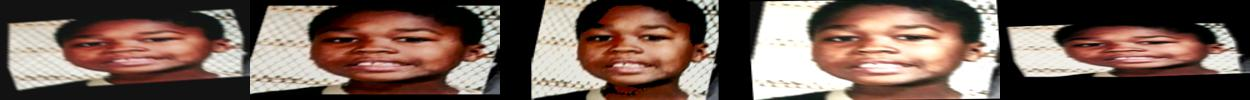

In [ ]:
# Augmentation sample images
generate_sample()
